In [86]:
import os
import re
import numpy as np

def load_ppg_signals_from_folder(folder_path):
    """
    Load raw PPG signals from a folder where all .txt files are located.
    
    Parameters:
    - folder_path: Path to the folder containing all .txt files.
    
    Returns:
    - ppg_data: A dictionary where keys are subject IDs and values are lists of signal segments.
    """
    ppg_data = {}
    # Regular expression to extract subject ID and segment number
    file_pattern = re.compile(r"(\d+)_(\d+)\.txt")

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            match = file_pattern.match(filename)
            if match:
                subject_id = int(match.group(1))
                segment_id = int(match.group(2))
                
                # Load the raw PPG signal from the file
                file_path = os.path.join(folder_path, filename)
                raw_signal = np.loadtxt(file_path)
                
                # Store in the dictionary
                if subject_id not in ppg_data:
                    ppg_data[subject_id] = []
                
                # Append the signal according to its segment number
                ppg_data[subject_id].append((segment_id, raw_signal))
    
    # Sort the segments by their segment number for each subject
    for subject_id in ppg_data:
        ppg_data[subject_id] = [signal for _, signal in sorted(ppg_data[subject_id])]
    
    return ppg_data

# Example usage
folder_path = '0_subject'
ppg_signals = load_ppg_signals_from_folder(folder_path)

In [87]:
import pywt
from scipy.signal import savgol_filter

def dwt_filtering(ppg_signal, wavelet='db8'):
    """Apply DWT filtering for denoising with dynamic level selection."""
    max_level = pywt.dwt_max_level(len(ppg_signal), pywt.Wavelet(wavelet).dec_len)
    level = min(max_level, 12)  # Ensure the level doesn't exceed a safe maximum
    coeffs = pywt.wavedec(ppg_signal, wavelet, level=level)
    coeffs[-1] = np.zeros_like(coeffs[-1])  # Suppress high-frequency coefficients
    filtered_signal = pywt.waverec(coeffs, wavelet)
    return filtered_signal


def sg_filtering(ppg_signal, window_length=61, polyorder=4):
    """Apply Savitzky-Golay filtering for smoothing."""
    smoothed_signal = savgol_filter(ppg_signal, window_length, polyorder)
    return smoothed_signal

def preprocess_ppg_signal(ppg_signal):
    """Preprocess raw PPG signal using DWT and Savitzky-Golay filters."""
    filtered_signal = dwt_filtering(ppg_signal)
    smoothed_signal = sg_filtering(filtered_signal)
    return smoothed_signal

# Example: Preprocess the signals for all subjects
preprocessed_ppg_signals = {}

for subject_id, segments in ppg_signals.items():
    preprocessed_ppg_signals[subject_id] = []
    for segment in segments:
        preprocessed_signal = preprocess_ppg_signal(segment)
        preprocessed_ppg_signals[subject_id].append(preprocessed_signal)

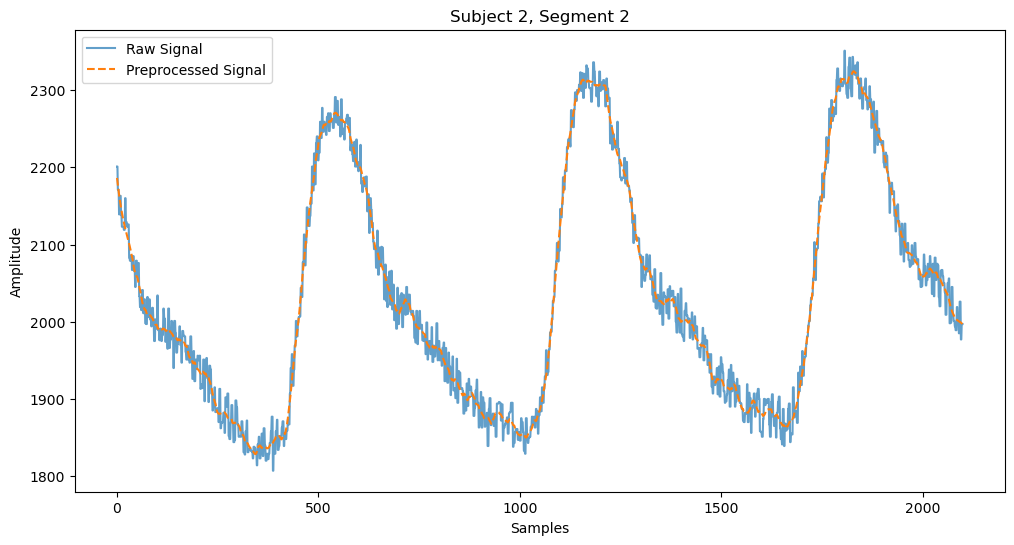

In [88]:
import matplotlib.pyplot as plt

subject_id = 2
segment_id = 1  # First segment

plot_signals(ppg_signals[subject_id][segment_id], preprocessed_ppg_signals[subject_id][segment_id], title=f"Subject {subject_id}, Segment {segment_id+1}")

In [89]:
import os
import numpy as np

def compute_higher_order_derivatives(preprocessed_signal):
    """
    Compute the second (APPG) and third (JPPG) derivatives of the preprocessed PPG signal.
    
    Parameters:
    - preprocessed_signal: The preprocessed PPG signal (after filtering).
    
    Returns:
    - appg: Second derivative (Acceleration Plethysmogram - APPG).
    - jppg: Third derivative (Jerk PPG - JPPG).
    """
    # First derivative (Velocity Plethysmogram - VPG)
    vpg = np.gradient(preprocessed_signal)
    
    # Second derivative (Acceleration Plethysmogram - APPG)
    appg = np.gradient(vpg)
    
    # Third derivative (Jerk PPG - JPPG)
    jppg = np.gradient(appg)
    
    return appg, jppg

def process_all_subjects_and_segments(ppg_signals):
    """
    Compute higher-order derivatives for all segments of all subjects.
    
    Parameters:
    - ppg_signals: A dictionary containing PPG signals for each subject and their segments.
    
    Returns:
    - derivatives: A dictionary containing APPG and JPPG for each subject and segment.
    """
    derivatives = {}
    
    for subject_id, segments in ppg_signals.items():
        derivatives[subject_id] = {'APPG': [], 'JPPG': []}
        
        for segment in segments:
            # Preprocess the segment (you can add your preprocessing function here)
            # Assuming the signals are already preprocessed
            preprocessed_signal = segment
            
            # Compute APPG and JPPG
            appg, jppg = compute_higher_order_derivatives(preprocessed_signal)
            
            # Store the derivatives for this segment
            derivatives[subject_id]['APPG'].append(appg)
            derivatives[subject_id]['JPPG'].append(jppg)
    
    return derivatives

# Example usage:
# Assuming ppg_signals is a dictionary with preprocessed PPG signals for each subject and their segments
# Example structure of ppg_signals:
# ppg_signals = {
#     1: [segment_1_data, segment_2_data, segment_3_data],
#     2: [segment_1_data, segment_2_data, segment_3_data],
#     ...
# }

# Compute derivatives for all subjects and segments
# ppg_signals = <your preprocessed PPG signals dictionary>
derivatives = process_all_subjects_and_segments(preprocessed_ppg_signals)

# Now derivatives contain the APPG and JPPG for all subjects and segments

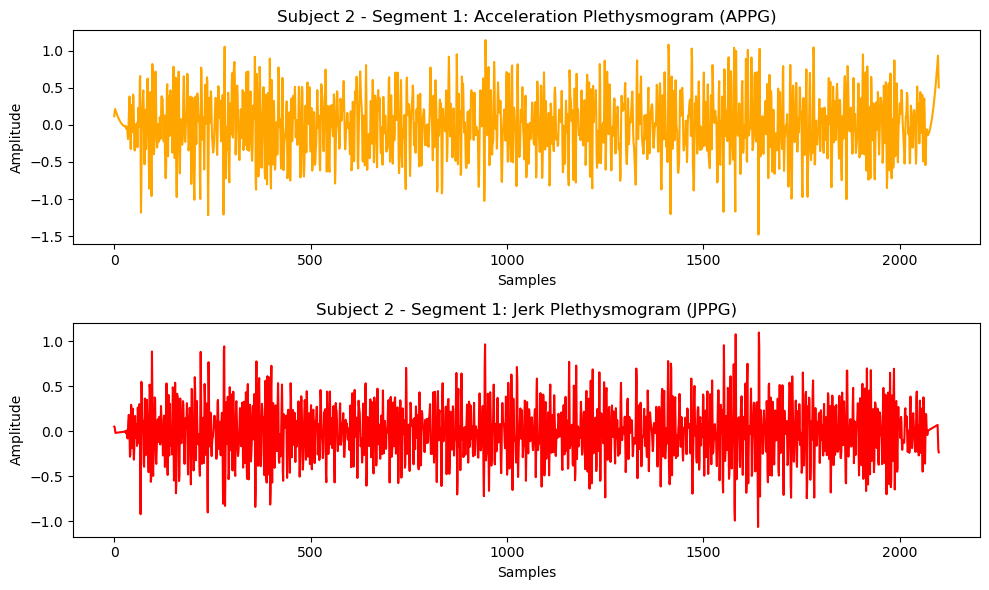

In [90]:
import matplotlib.pyplot as plt

def plot_appg_jppg(appg, jppg, subject_id, segment_id):
    """
    Plot APPG (second derivative) and JPPG (third derivative) for a given subject and segment.
    
    Parameters:
    - appg: Second derivative (APPG) for the selected subject and segment.
    - jppg: Third derivative (JPPG) for the selected subject and segment.
    - subject_id: The ID of the subject.
    - segment_id: The ID of the segment.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot APPG
    plt.subplot(2, 1, 1)
    plt.plot(appg, label='APPG (Second Derivative)', color='orange')
    plt.title(f'Subject {subject_id} - Segment {segment_id + 1}: Acceleration Plethysmogram (APPG)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    
    # Plot JPPG
    plt.subplot(2, 1, 2)
    plt.plot(jppg, label='JPPG (Third Derivative)', color='red')
    plt.title(f'Subject {subject_id} - Segment {segment_id + 1}: Jerk Plethysmogram (JPPG)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming derivatives is a dictionary with APPG and JPPG for each subject and segment
# For example:
# appg = derivatives[1]['APPG'][0]  # Second derivative (APPG) for subject 1, segment 1
# jppg = derivatives[1]['JPPG'][0]  # Third derivative (JPPG) for subject 1, segment 1

subject_id = 2  # Example subject ID
segment_id = 0  # Example segment ID

# Example: Visualize APPG and JPPG for Subject 1, Segment 1
plot_appg_jppg(derivatives[subject_id]['APPG'][segment_id - 1], 
               derivatives[subject_id]['JPPG'][segment_id - 1], 
               subject_id, segment_id)

In [91]:
import numpy as np
from scipy.signal import welch
from scipy.stats import entropy
import math

# Spectral Entropy
from scipy.signal import welch
import numpy as np

def spectral_entropy(signal, fs=1.0):
    # Calculate Power Spectral Density (PSD)
    f, Pxx = welch(signal, fs=fs)
    
    # Normalize PSD
    Pxx_norm = Pxx / np.sum(Pxx)
    
    # Calculate Spectral Entropy
    spectral_entropy_value = -np.sum(Pxx_norm * np.log2(Pxx_norm + 1e-12))  # Add small value to avoid log(0)
    return spectral_entropy_value

# Attention Entropy
def attention_entropy(signal):
    # Identify key changes in the signal (where the slope changes)
    key_changes = np.where(np.diff(np.sign(np.diff(signal))) != 0)[0]
    
    # Calculate the distances (intervals) between key changes
    intervals = np.diff(key_changes)
    
    # Normalize the intervals
    prob_intervals = intervals / np.sum(intervals)
    
    # Calculate Attention Entropy
    attention_entropy_value = -np.sum(prob_intervals * np.log2(prob_intervals + 1e-12))  # Add small value to avoid log(0)
    return attention_entropy_value

# Dispersion Entropy
def dispersion_entropy(signal, m=3, c=5):
    # Normalize the signal
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    
    # Quantize the signal into 'c' bins
    bins = np.linspace(0, 1, c)
    quantized_signal = np.digitize(signal, bins) - 1
    
    # Create embedding matrix
    embedded_matrix = np.array([quantized_signal[i:i+m] for i in range(len(quantized_signal) - m + 1)])
    
    # Count the frequency of each unique pattern
    unique_patterns, counts = np.unique(embedded_matrix, axis=0, return_counts=True)
    
    # Normalize the counts to get probabilities
    probabilities = counts / np.sum(counts)
    
    # Calculate Dispersion Entropy
    dispersion_entropy_value = -np.sum(probabilities * np.log2(probabilities + 1e-12))
    return dispersion_entropy_value

# Slope Entropy (Using simplified slope calculation for demonstration)
def slope_entropy(signal):
    # Compute the slopes of the signal
    slopes = np.diff(signal)
    
    # Symbolize the slopes: -1 for negative, 0 for zero, and 1 for positive
    slope_symbols = np.sign(slopes)
    
    # Count the frequency of each slope category
    unique, counts = np.unique(slope_symbols, return_counts=True)
    
    # Normalize the counts to get probabilities
    probabilities = counts / np.sum(counts)
    
    # Calculate Slope Entropy
    slope_entropy_value = -np.sum(probabilities * np.log2(probabilities + 1e-12))
    return slope_entropy_value

# Function to compute all entropies for a given APPG and JPPG segment
def compute_all_entropies(appg, jppg):
    """Compute all entropy features for both APPG and JPPG."""
    entropies = {
        'APPG': {
            'Spectral Entropy': spectral_entropy(appg),
            'Attention Entropy': attention_entropy(appg),
            'Dispersion Entropy': dispersion_entropy(appg),
            'Slope Entropy': slope_entropy(appg),
        },
        'JPPG': {
            'Spectral Entropy': spectral_entropy(jppg),
            'Attention Entropy': attention_entropy(jppg),
            'Dispersion Entropy': dispersion_entropy(jppg),
            'Slope Entropy': slope_entropy(jppg),
        }
    }
    return entropies

# Process all subjects and segments
def extract_entropy_features_for_all_segments(ppg_signals):
    """Extract entropy features for all segments of all subjects."""
    features = []
    labels = []  # Store CI (1) or Normal (0) labels

    for subject_id, signals in ppg_signals.items():
        for segment in signals:
            # Preprocess each segment (assuming preprocessed_signal is used directly here)
            preprocessed_signal = segment
            
            # Compute higher-order derivatives
            appg, jppg = compute_higher_order_derivatives(preprocessed_signal)
            
            # Compute entropy features for APPG and JPPG
            entropy_values = compute_all_entropies(appg, jppg)
            
            # Prepare the feature vector with all entropies
            feature_vector = [
                entropy_values['APPG']['Spectral Entropy'],
                entropy_values['APPG']['Attention Entropy'],
                entropy_values['APPG']['Dispersion Entropy'],
                entropy_values['APPG']['Slope Entropy'],
                entropy_values['JPPG']['Spectral Entropy'],
                entropy_values['JPPG']['Attention Entropy'],
                entropy_values['JPPG']['Dispersion Entropy'],
                entropy_values['JPPG']['Slope Entropy'],
            ]
            features.append(feature_vector)
            
            # Assuming that your subject label is derived from subject_id (1 = CI, 0 = Normal)
            labels.append(1 if subject_id == 2 else 0)  # You can replace this logic based on your dataset
    return np.array(features), np.array(labels)

# Example usage: extract features for all subjects
features, labels = extract_entropy_features_for_all_segments(preprocessed_ppg_signals)

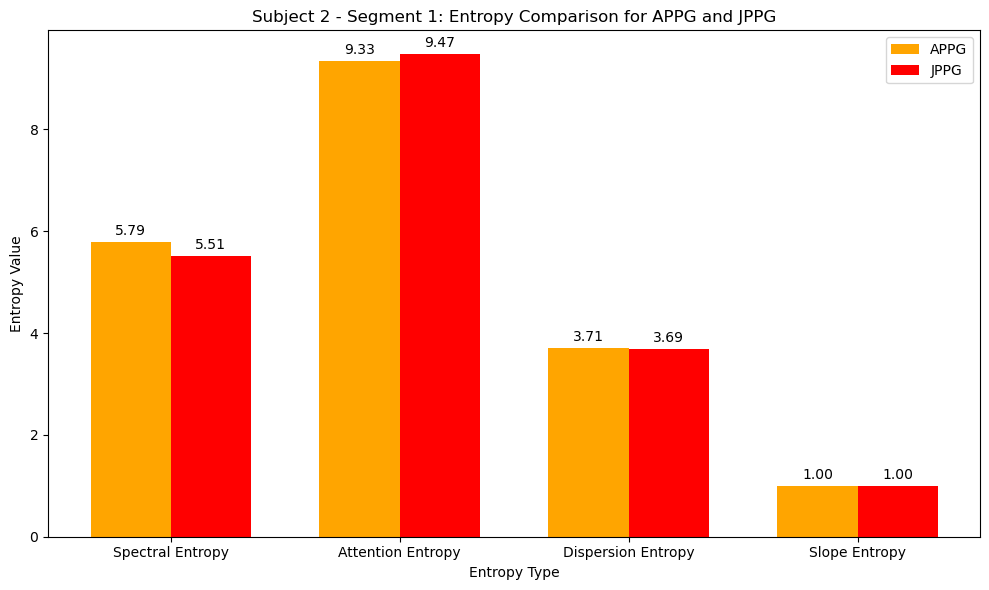

In [92]:
import matplotlib.pyplot as plt
import numpy as np

def plot_entropy(entropies, subject_id, segment_id):
    """
    Plot all entropy features (Spectral, Attention, Dispersion, Slope) for both APPG and JPPG of a given subject and segment.
    
    Parameters:
    - entropies: The dictionary containing entropy values for all subjects and segments.
    - subject_id: The ID of the subject.
    - segment_id: The ID of the segment.
    """
    appg_entropies = entropies[subject_id]['APPG'][segment_id]
    jppg_entropies = entropies[subject_id]['JPPG'][segment_id]

    # Extract the entropy values
    appg_values = list(appg_entropies.values())
    jppg_values = list(jppg_entropies.values())

    # Labels for the entropy features
    entropy_labels = list(appg_entropies.keys())

    x = np.arange(len(entropy_labels))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot APPG and JPPG entropies side by side
    bars_appg = ax.bar(x - width/2, appg_values, width, label='APPG', color='orange')
    bars_jppg = ax.bar(x + width/2, jppg_values, width, label='JPPG', color='red')

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Entropy Type')
    ax.set_ylabel('Entropy Value')
    ax.set_title(f'Subject {subject_id} - Segment {segment_id+1}: Entropy Comparison for APPG and JPPG')
    ax.set_xticks(x)
    ax.set_xticklabels(entropy_labels)
    ax.legend()

    # Display values on top of the bars
    for bars in [bars_appg, bars_jppg]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming entropies is the dictionary containing entropy values for all subjects and segments
# Example: Visualize entropy features for Subject 1, Segment 1
subject_id = 2  # Replace with your subject ID
segment_id = 0  # Segment ID (0-indexed)

plot_entropy(entropies, subject_id, segment_id)

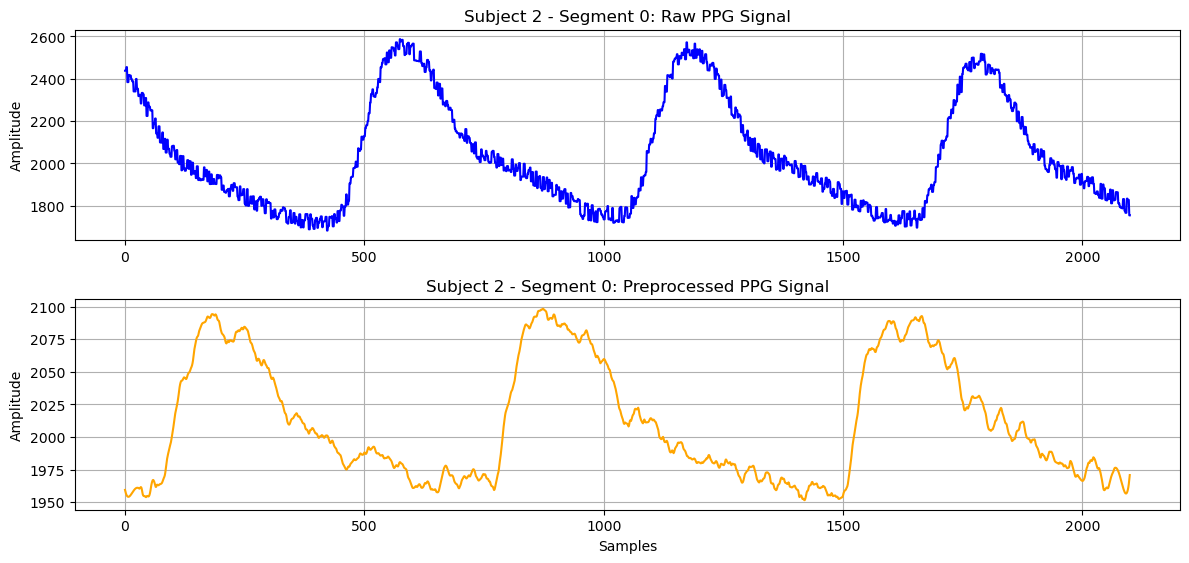

In [93]:
import matplotlib.pyplot as plt

def plot_signal_comparison(raw_signal, reprocessed_signal, subject_id, segment_id):
    plt.figure(figsize=(12, 8))
    
    # Raw Signal
    plt.subplot(3, 1, 1)
    plt.plot(raw_signal, color='blue')
    plt.title(f'Subject {subject_id} - Segment {segment_id}: Raw PPG Signal')
    plt.ylabel('Amplitude')
    plt.grid(True)

     # Preprocessed Signal (Filtered + Smoothed)
    plt.subplot(3, 1, 2)
    plt.plot(preprocessed_signal, color='orange')
    plt.title(f'Subject {subject_id} - Segment {segment_id}: Preprocessed PPG Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage

subject_id = 2  # Example subject ID
segment_id = 0  # Example segment ID
plot_signal_comparison(ppg_signals[subject_id][segment_id], preprocessed_ppg_signals, subject_id, segment_id)


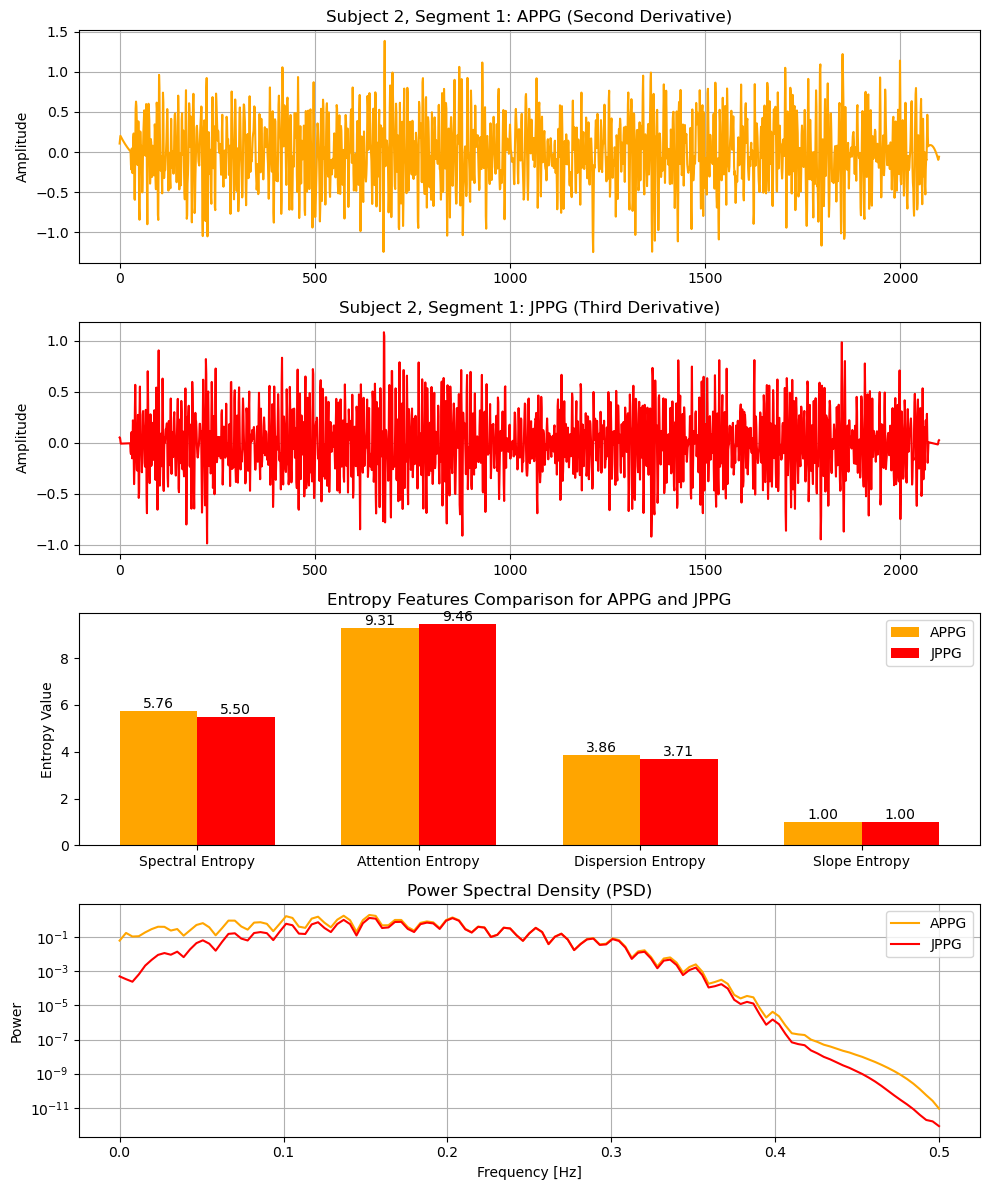

In [94]:
def plot_derivatives_with_entropy(appg, jppg, entropy_values, subject_id, segment_id):
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))

    # APPG (Second Derivative)
    axs[0].plot(appg, color='orange')
    axs[0].set_title(f'Subject {subject_id}, Segment {segment_id + 1}: APPG (Second Derivative)')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)

    # JPPG (Third Derivative)
    axs[1].plot(jppg, color='red')
    axs[1].set_title(f'Subject {subject_id}, Segment {segment_id + 1}: JPPG (Third Derivative)')
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)

    # Entropy Features Bar Plot
    entropy_labels = list(entropy_values['APPG'].keys())
    appg_values = list(entropy_values['APPG'].values())
    jppg_values = list(entropy_values['JPPG'].values())

    x = np.arange(len(entropy_labels))
    width = 0.35

    axs[2].bar(x - width/2, appg_values, width, label='APPG', color='orange')
    axs[2].bar(x + width/2, jppg_values, width, label='JPPG', color='red')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(entropy_labels)
    axs[2].set_title('Entropy Features Comparison for APPG and JPPG')
    axs[2].set_ylabel('Entropy Value')
    axs[2].legend()

    # Display Entropy values for each bar
    for i in range(len(x)):
        axs[2].annotate(f'{appg_values[i]:.2f}', xy=(x[i] - width/2, appg_values[i]), ha='center', va='bottom')
        axs[2].annotate(f'{jppg_values[i]:.2f}', xy=(x[i] + width/2, jppg_values[i]), ha='center', va='bottom')

    # Power Spectral Density Plot for one of the entropy features (e.g., Spectral Entropy)
    f, Pxx = welch(appg)
    axs[3].semilogy(f, Pxx, label='APPG', color='orange')
    f, Pxx = welch(jppg)
    axs[3].semilogy(f, Pxx, label='JPPG', color='red')
    axs[3].set_title('Power Spectral Density (PSD)')
    axs[3].set_xlabel('Frequency [Hz]')
    axs[3].set_ylabel('Power')
    axs[3].grid(True)
    axs[3].legend()

    plt.tight_layout()
    plt.show()

# Example usage
entropy_values = compute_all_entropies(appg, jppg)
plot_derivatives_with_entropy(appg, jppg, entropy_values, subject_id, segment_id)


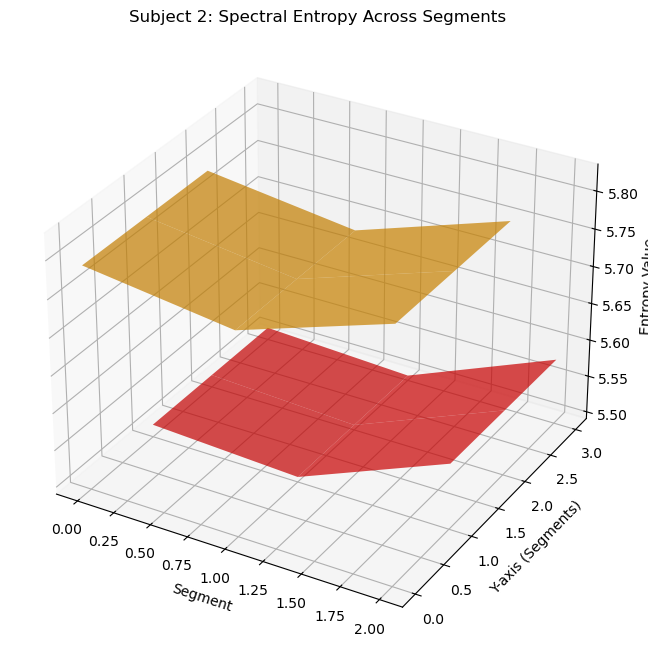

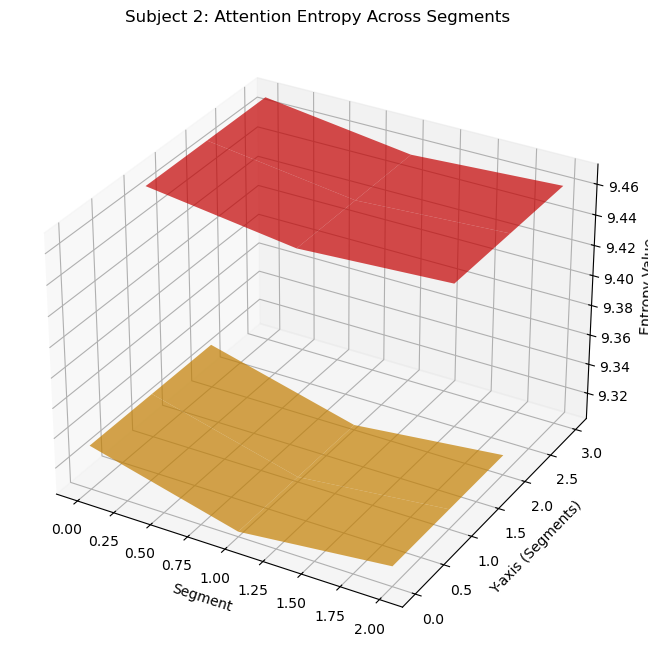

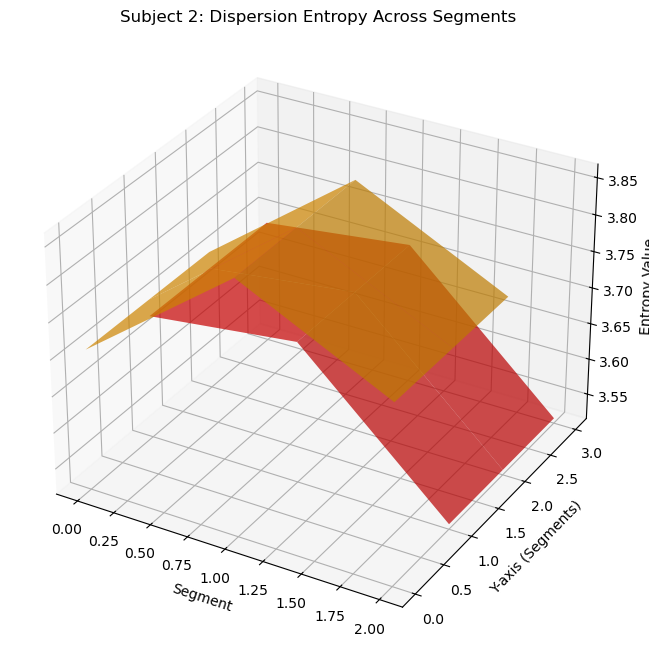

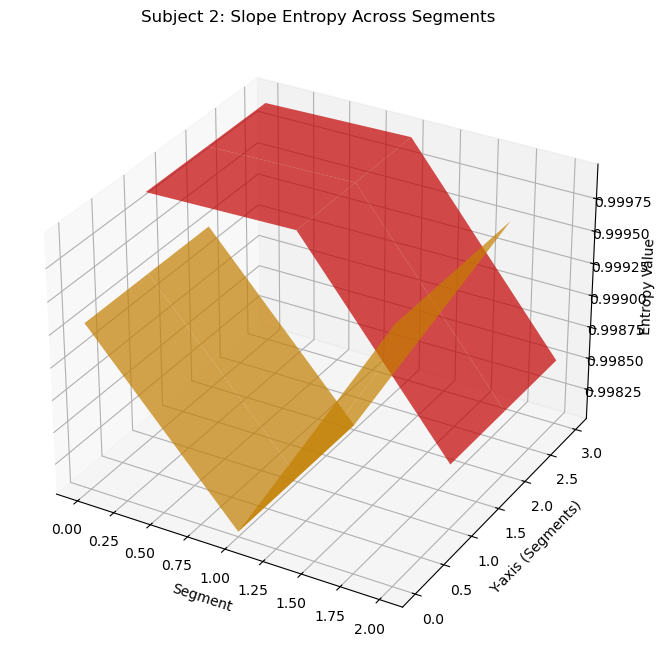

In [95]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_entropy_surface(entropies, subject_id, entropy_type='Spectral Entropy'):
    segments = len(entropies[subject_id]['APPG'])
    X = np.arange(segments)
    Y = np.arange(segments)  # Add some variation to Y instead of using the same value
    Z_appg = np.array([entropies[subject_id]['APPG'][i][entropy_type] for i in range(segments)])
    Z_jppg = np.array([entropies[subject_id]['JPPG'][i][entropy_type] for i in range(segments)])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create meshgrid for plotting surface
    X, Y = np.meshgrid(X, Y)
    Z_appg = np.tile(Z_appg, (segments, 1))  # Adjust Z to match the meshgrid
    Z_jppg = np.tile(Z_jppg, (segments, 1))

    # Plot surfaces instead of trisurfs
    ax.plot_surface(X, Y, Z_appg, color='orange', alpha=0.7, label='APPG')
    ax.plot_surface(X, Y + 1, Z_jppg, color='red', alpha=0.7, label='JPPG')

    ax.set_title(f'Subject {subject_id}: {entropy_type} Across Segments')
    ax.set_xlabel('Segment')
    ax.set_ylabel('Y-axis (Segments)')
    ax.set_zlabel('Entropy Value')

    plt.show()

# Example usage
plot_3d_entropy_surface(entropies, subject_id, 'Spectral Entropy')
plot_3d_entropy_surface(entropies, subject_id, 'Attention Entropy')
plot_3d_entropy_surface(entropies, subject_id, 'Dispersion Entropy')
plot_3d_entropy_surface(entropies, subject_id, 'Slope Entropy')


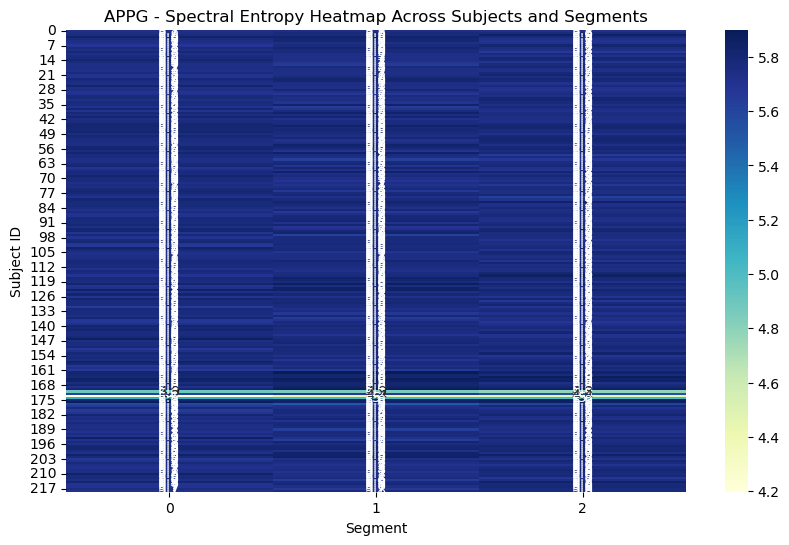

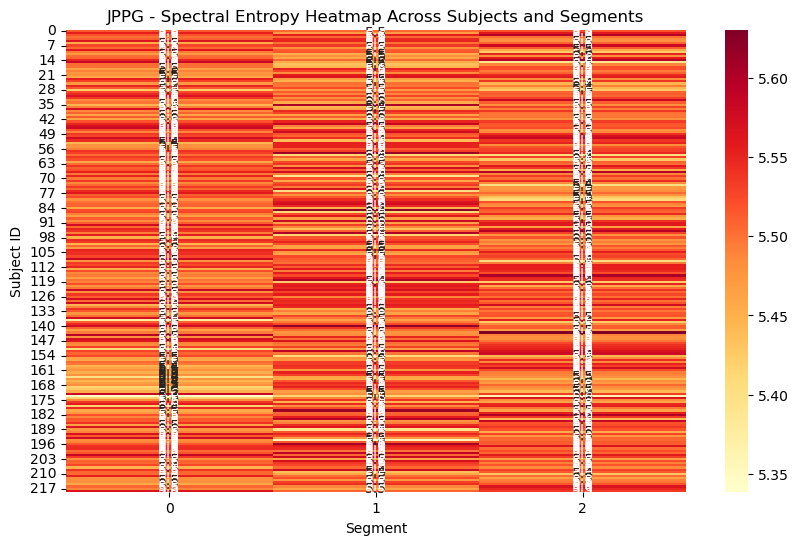

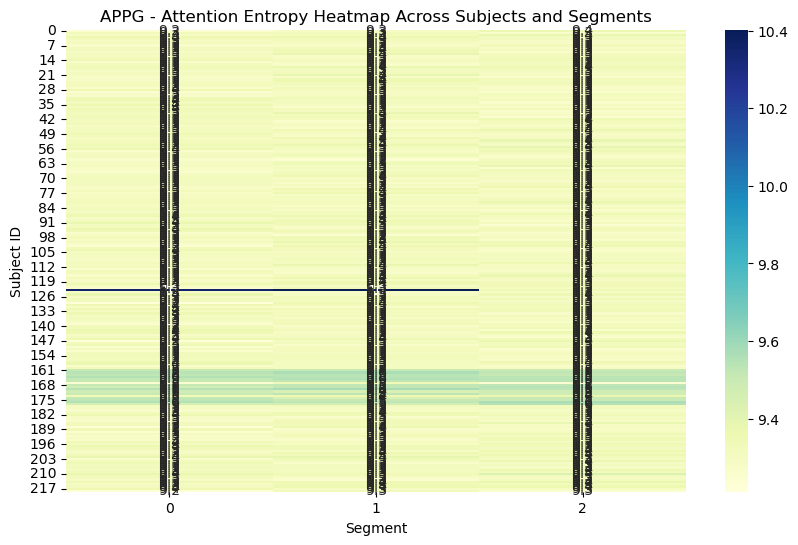

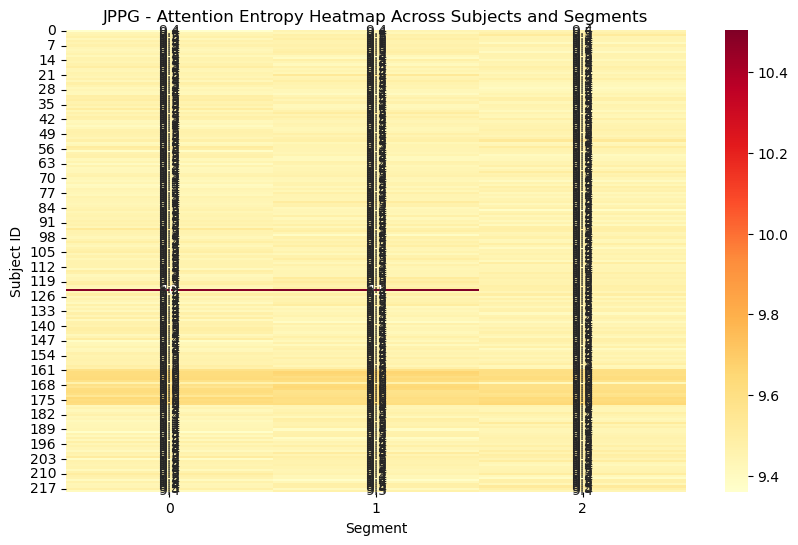

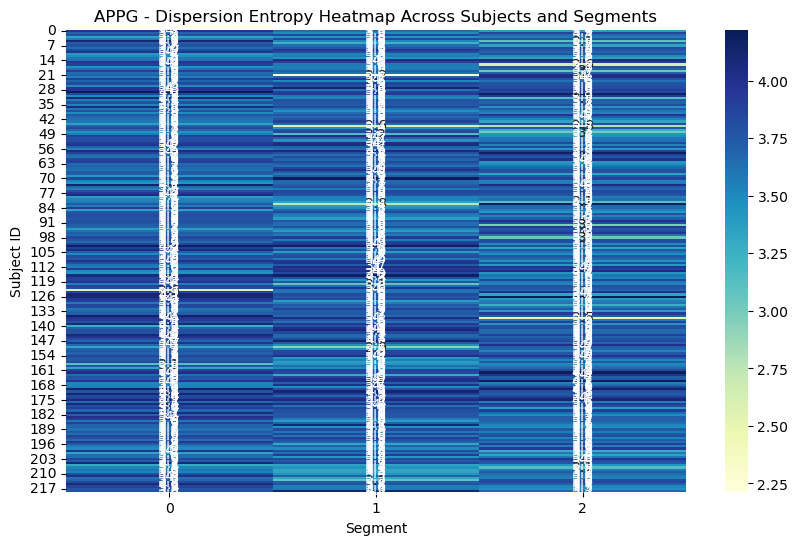

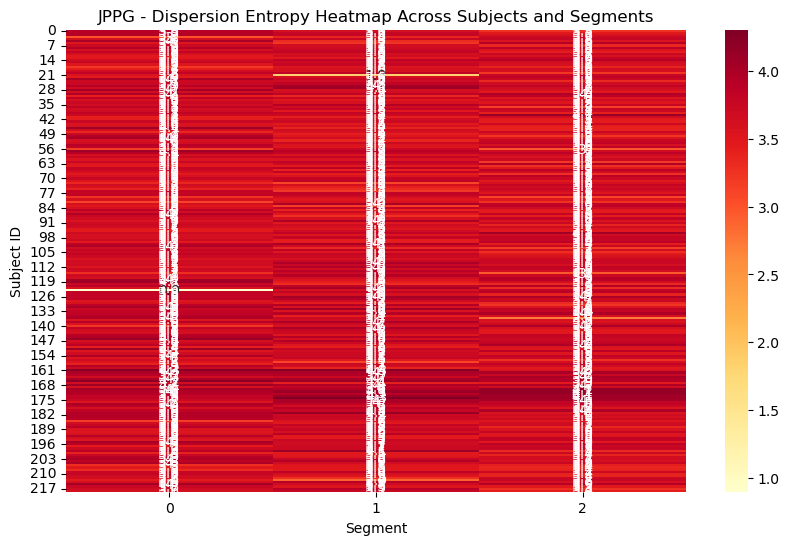

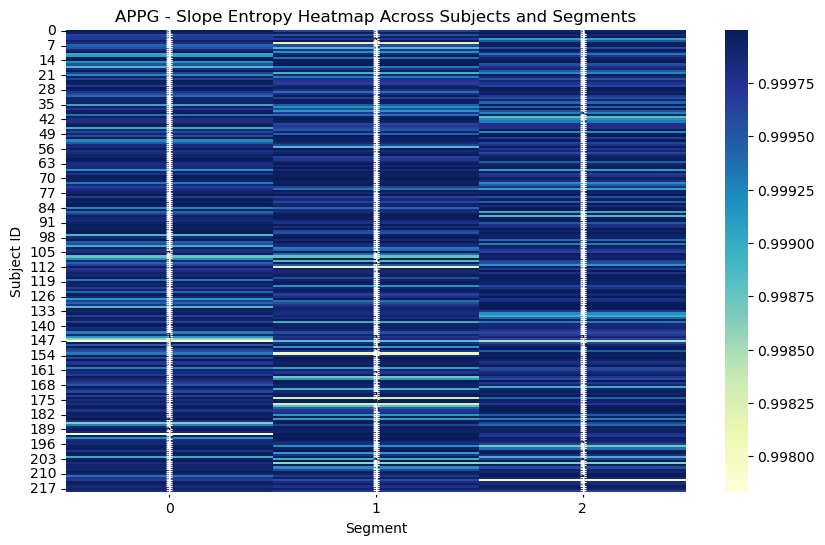

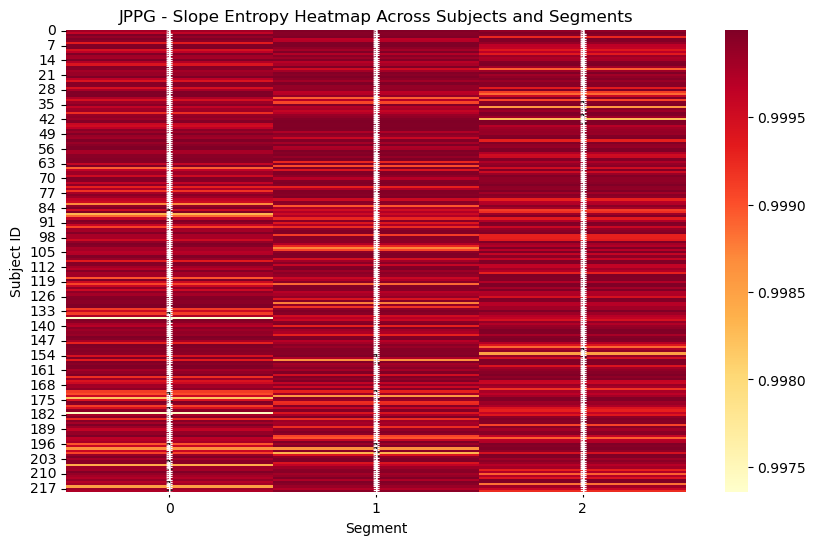

In [96]:
import seaborn as sns

def plot_entropy_heatmap(entropies, entropy_type='Spectral Entropy'):
    # Prepare data for heatmap (rows: subjects, columns: segments)
    data_appg = []
    data_jppg = []

    for subject_id in entropies:
        segments_appg = [entropies[subject_id]['APPG'][i][entropy_type] for i in range(len(entropies[subject_id]['APPG']))]
        segments_jppg = [entropies[subject_id]['JPPG'][i][entropy_type] for i in range(len(entropies[subject_id]['JPPG']))]
        data_appg.append(segments_appg)
        data_jppg.append(segments_jppg)

    # Plot Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(data_appg, cmap="YlGnBu", annot=True, cbar=True)
    plt.title(f'APPG - {entropy_type} Heatmap Across Subjects and Segments')
    plt.ylabel('Subject ID')
    plt.xlabel('Segment')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(data_jppg, cmap="YlOrRd", annot=True, cbar=True)
    plt.title(f'JPPG - {entropy_type} Heatmap Across Subjects and Segments')
    plt.ylabel('Subject ID')
    plt.xlabel('Segment')
    plt.show()

# Example usage
plot_entropy_heatmap(entropies, 'Spectral Entropy')
plot_entropy_heatmap(entropies, 'Attention Entropy')
plot_entropy_heatmap(entropies, 'Dispersion Entropy')
plot_entropy_heatmap(entropies, 'Slope Entropy')


In [100]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Stratified split to ensure class distribution is the same in train and test sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42, k_neighbors=1)  # Reduce k_neighbors to 1
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Train and evaluate SVM
svm_model = SVC(kernel='rbf', gamma='auto', probability=True)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)

# Train and evaluate Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_nb = nb_model.predict(X_test)

# Train and evaluate KNN
knn_model = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test)

# Evaluate the models
svm_accuracy = accuracy_score(y_test, y_pred_svm)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

# Check if both classes are present in the test set
if len(np.unique(y_test)) > 1:
    # AUC-ROC score can only be calculated if both classes are present
    svm_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])
    nb_auc = roc_auc_score(y_test, nb_model.predict_proba(X_test)[:, 1])
    knn_auc = roc_auc_score(y_test, knn_model.predict_proba(X_test)[:, 1])

    print(f"SVM Accuracy: {svm_accuracy:.2f}, AUC-ROC: {svm_auc:.2f}")
    print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}, AUC-ROC: {nb_auc:.2f}")
    print(f"KNN Accuracy: {knn_accuracy:.2f}, AUC-ROC: {knn_auc:.2f}")
else:
    print(f"SVM Accuracy: {svm_accuracy:.2f} (AUC-ROC not available, only one class in y_test)")
    print(f"Naive Bayes Accuracy: {nb_accuracy:.2f} (AUC-ROC not available, only one class in y_test)")
    print(f"KNN Accuracy: {knn_accuracy:.2f} (AUC-ROC not available, only one class in y_test)")

# Confusion Matrix
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

print("\nNaive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


SVM Accuracy: 0.98, AUC-ROC: 0.32
Naive Bayes Accuracy: 0.98, AUC-ROC: 0.80
KNN Accuracy: 0.95, AUC-ROC: 0.47

SVM Confusion Matrix:
[[130   1]
 [  1   0]]

Naive Bayes Confusion Matrix:
[[130   1]
 [  1   0]]

KNN Confusion Matrix:
[[126   5]
 [  1   0]]


C:\Users\anshu\AppData\Local\Temp\ipykernel_27460\2921165813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette='Set1')
C:\Users\anshu\AppData\Local\Temp\ipykernel_27460\2921165813.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette='Set2')


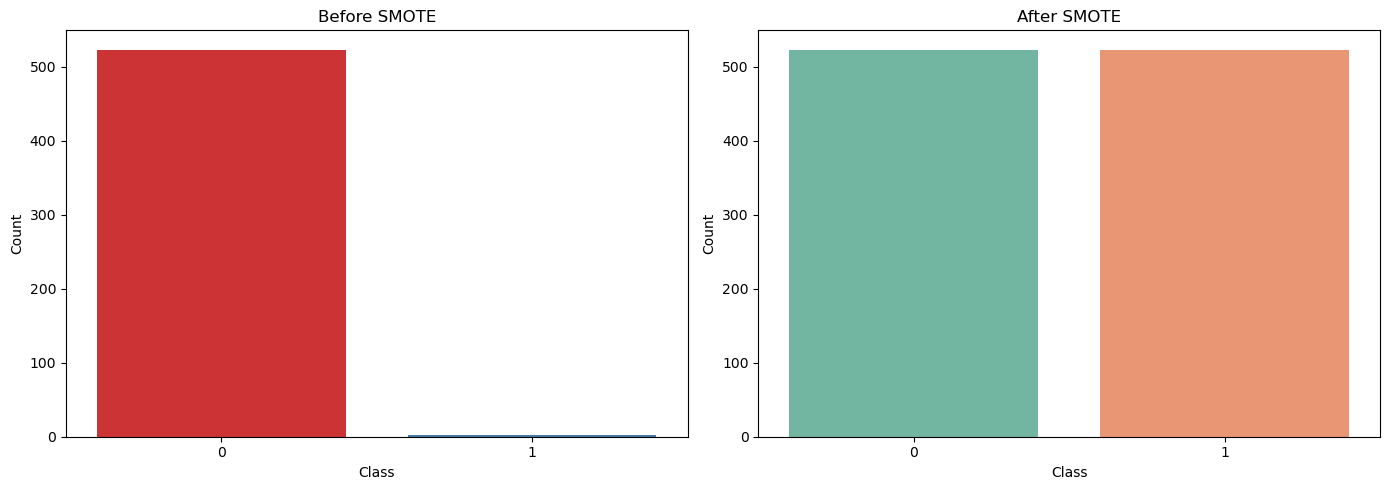

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(y_before, y_after, title_before="Before SMOTE", title_after="After SMOTE"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Before SMOTE
    sns.countplot(x=y_before, ax=ax[0], palette='Set1')
    ax[0].set_title(title_before)
    ax[0].set_xlabel('Class')
    ax[0].set_ylabel('Count')
    
    # After SMOTE
    sns.countplot(x=y_after, ax=ax[1], palette='Set2')
    ax[1].set_title(title_after)
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_class_distribution(y_train, y_train_resampled)


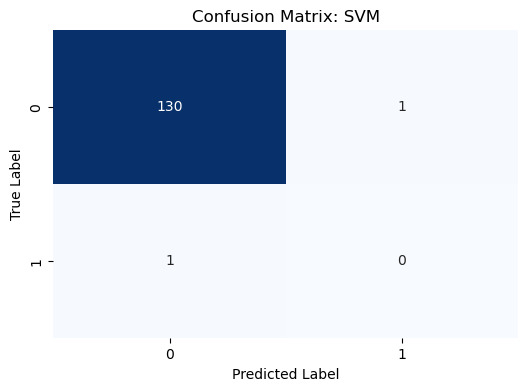

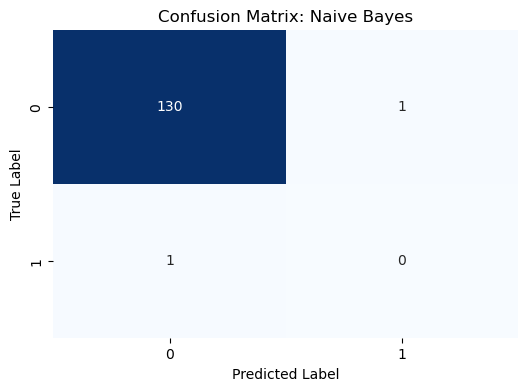

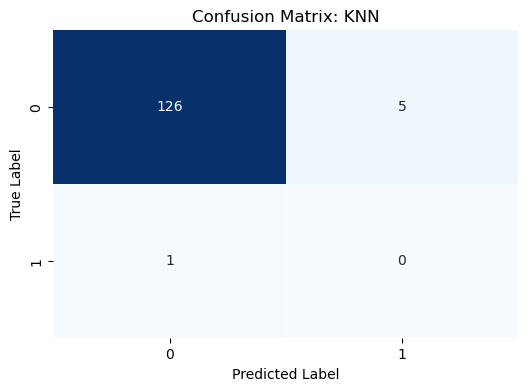

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Example usage:
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")


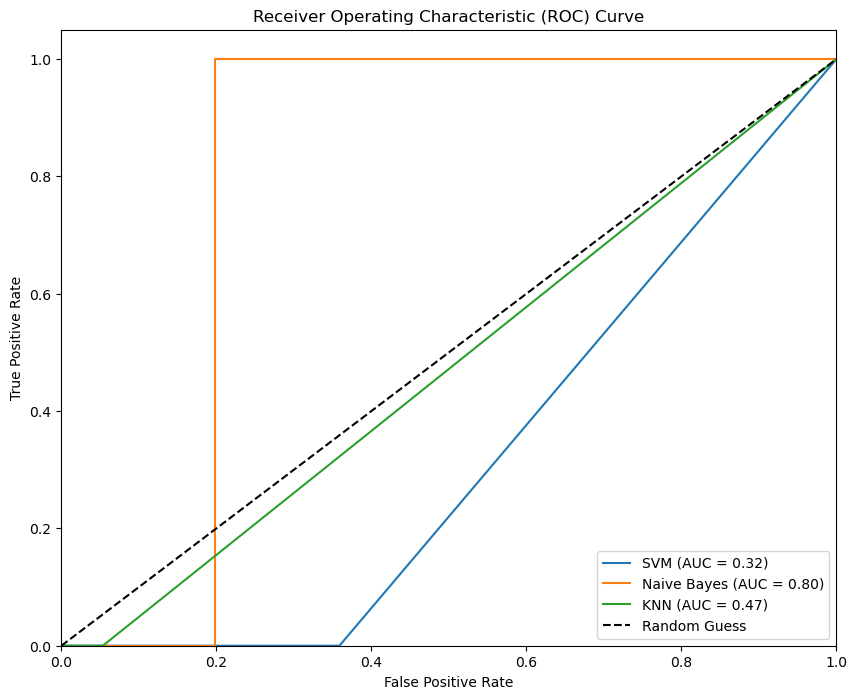

In [103]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models, X_test, y_test, model_names):
    plt.figure(figsize=(10, 8))
    
    for i, model in enumerate(models):
        if len(np.unique(y_test)) > 1:  # Check if both classes are present
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{model_names[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
models = [svm_model, nb_model, knn_model]
model_names = ["SVM", "Naive Bayes", "KNN"]
plot_roc_curve(models, X_test, y_test, model_names)


C:\Users\anshu\AppData\Local\Temp\ipykernel_27460\2921165813.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, ax=ax[0], palette='Set1')
C:\Users\anshu\AppData\Local\Temp\ipykernel_27460\2921165813.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, ax=ax[1], palette='Set2')


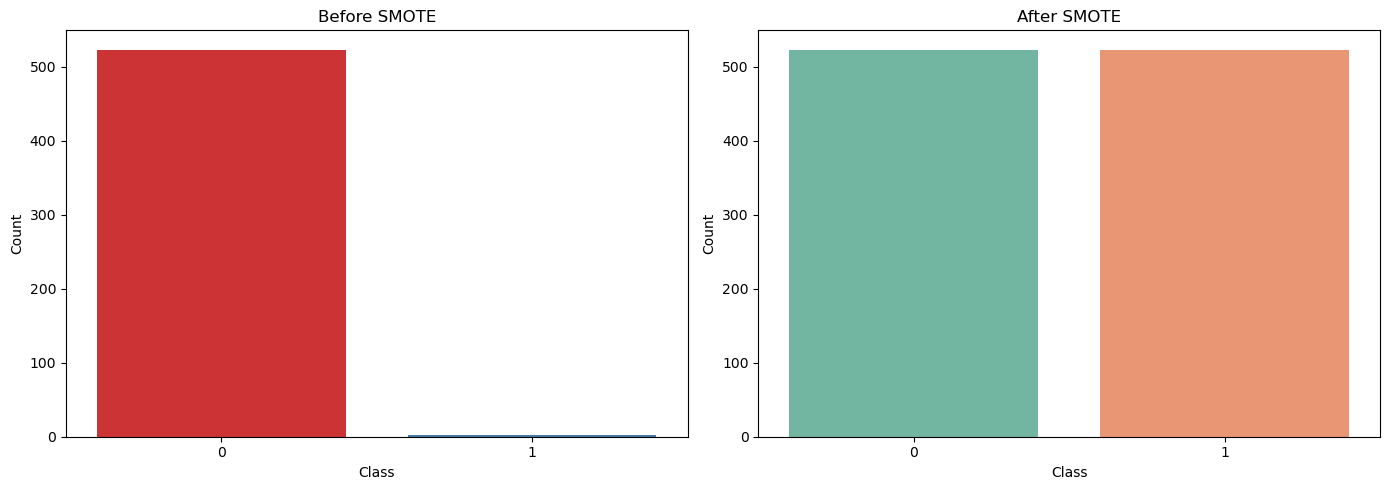

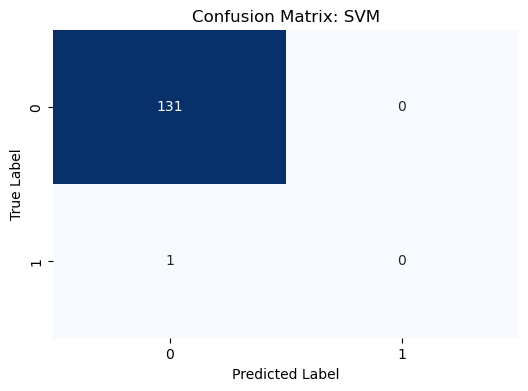

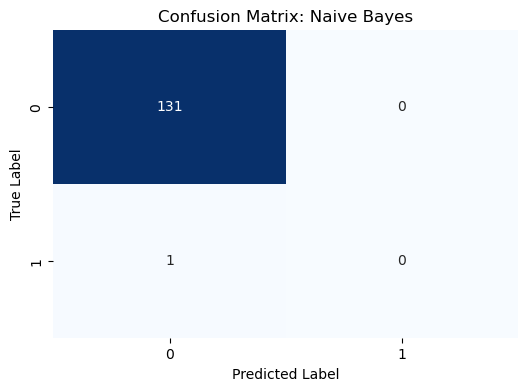

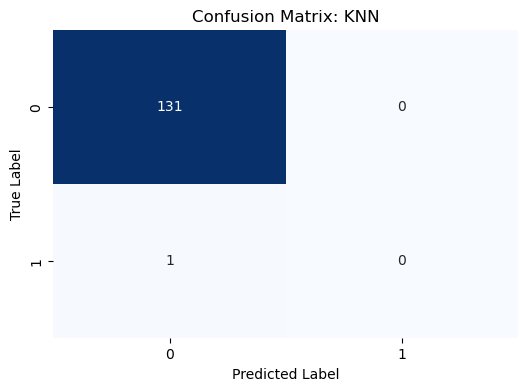

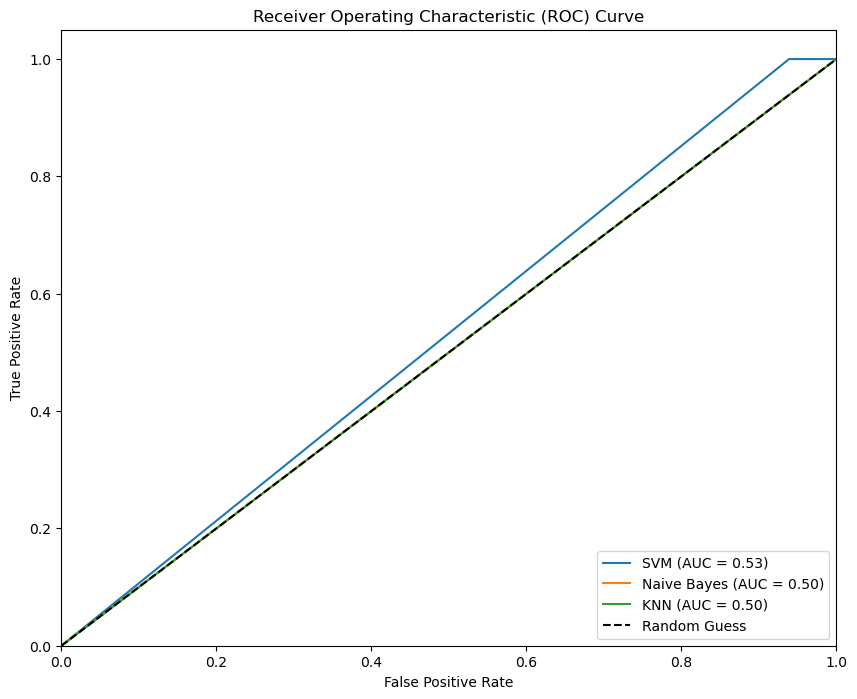

In [104]:
# Apply SMOTE with a reduced number of neighbors
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize class distribution before and after SMOTE
plot_class_distribution(y_train, y_train_resampled)

# Train and evaluate the models
svm_model = SVC(kernel='rbf', gamma='auto', probability=True)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)

nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_nb = nb_model.predict(X_test)

knn_model = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test)

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")

# Plot ROC curves for the models
models = [svm_model, nb_model, knn_model]
model_names = ["SVM", "Naive Bayes", "KNN"]
plot_roc_curve(models, X_test, y_test, model_names)
